change path to image dir

test dataset

data augmentation

cache, prefetch

overfitting

stratergy: simple model first

pipeline

MAE/MSE/RMSE

change lambda regu

In [1]:
!git clone https://github.com/LapTQ/facial_beauty_perception
%cd facial_beauty_perception/FBP5500/Images

Cloning into 'facial_beauty_perception'...
remote: Enumerating objects: 11152, done.
remote: Counting objects: 100% (11152/11152), done.
remote: Compressing objects: 100% (11137/11137), done.
remote: Total 11152 (delta 85), reused 11033 (delta 12), pack-reused 0
Receiving objects: 100% (11152/11152), 177.24 MiB | 7.41 MiB/s, done.
Resolving deltas: 100% (85/85), done.
Checking out files: 100% (11020/11020), done.
/content/facial_beauty_perception/FBP5500/Images


In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization, Conv2D, Activation, Add, Input, Dense, ZeroPadding2D, Flatten, AveragePooling2D, MaxPooling2D
from keras.initializers import he_normal
from keras.regularizers import L1, L2
from keras.models import Model

seed = 42

### Load images

In [3]:
image_size = (90, 90)
input_shape = (*image_size, 3)
batch_size = 32
scores_path = "https://github.com/LapTQ/facial_beauty_perception/raw/main/FBP5500/train_test_files/All_labels.csv"

scores_dataframe = pd.read_csv(
    scores_path,
    header=None,
    names=['file_name', 'score']
)

scores = scores_dataframe['score'].to_numpy().tolist()

In [4]:
scores_dataframe.head()

,file_name,score
0,AF1.jpg,2.333333
1,AF2.jpg,3.950000
2,AF3.jpg,3.183333
3,AF4.jpg,2.683333
4,AF5.jpg,2.000000


count    5500.000000
mean        2.990891
std         0.688112
min         1.016667
25%         2.500000
50%         2.833333
75%         3.533333
max         4.750000
Name: score, dtype: float64


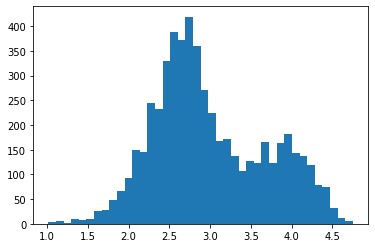

In [5]:
print(scores_dataframe['score'].describe())

plt.hist(scores_dataframe['score'], bins=40,)
plt.show()

In [6]:
images = []
for index in scores_dataframe.index:
    img = image.load_img(scores_dataframe['file_name'][index], target_size=image_size)
    img = image.img_to_array(img)
    images.append(img/255.)

In [7]:
images = np.array(images)
scores = np.array(scores)
np.random.seed(seed)
np.random.shuffle(images)
np.random.seed(seed)
np.random.shuffle(scores)

In [8]:
print(images.shape)
print(scores.shape)

(5500, 90, 90, 3)
(5500,)


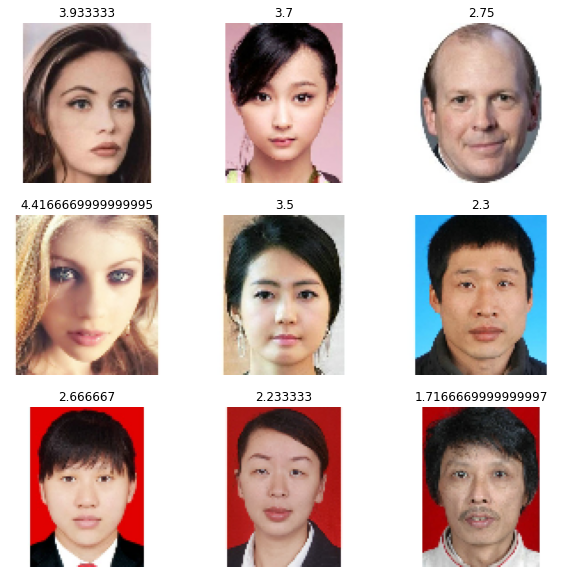

In [9]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(scores[i])
    plt.axis("off")

### Create dataset

In [10]:
n_train = 4400
v_validation = 1100
buffer_size = 5500

In [11]:
images_ds = tf.data.Dataset.from_tensor_slices(images)
scores_ds = tf.data.Dataset.from_tensor_slices(scores)

x_train = images_ds.take(n_train)
x_val = images_ds.skip(n_train)

y_train = scores_ds.take(n_train)
y_val = scores_ds.skip(n_train)

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

x_val_prefetch = x_val.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
x_train_prefetch = x_train.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

y_val_prefetch = y_val.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
y_train_prefetch = y_train.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [13]:
ds = tf.data.Dataset.from_tensor_slices((images, scores))

train_ds = ds.take(n_train)
val_ds = ds.skip(n_train)

In [14]:
tiny_val_ds = val_ds.take(5).cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
tiny_train_ds = train_ds.take(5).cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [15]:
small_val_ds = val_ds.take(27).cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
small_train_ds = train_ds.take(27).cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [16]:
medium_val_ds = val_ds.take(64).cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
medium_train_ds = train_ds.take(64).cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [17]:
large_val_ds = val_ds.take(100).cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
large_train_ds = train_ds.take(100).cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [18]:
val_ds_prefetch = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
train_ds_prefetch = train_ds.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

### Build architectures

In [19]:
def identity_block(X, f, filters, training=True):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # retrieve filters
    F1, F2, F3 = filters

    # save the input value
    X_shortcut = X

    # first component of main path
    X = Conv2D(filters=F1, kernel_size=1, strides=1, padding='valid', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # second component of main path
    X = Conv2D(filters=F2, kernel_size=f, strides=1, padding='same', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # third component of main path
    X = Conv2D(filters=F3, kernel_size=1, strides=1, padding='valid', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)

    # add shortcut value to main path and pass it through a RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

    

In [20]:
def convolutional_block(X, f, filters, s=2, training=True):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # retrieve filters
    F1, F2, F3 = filters

    # save the input value
    X_shortcut = X

    # first component of main path
    X = Conv2D(F1, kernel_size=1, strides=s, padding='valid', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # second component of main path
    X = Conv2D(F2, kernel_size=f, strides=1, padding='same', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # third component of main path
    X = Conv2D(F3, kernel_size=1, strides=1, padding='valid', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)

    # shortcut path
    X_shortcut = Conv2D(F3, kernel_size=1, strides=s, padding='valid', kernel_initializer=he_normal(seed=seed))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)

    # add shortcut to main path, and pass it through a RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [21]:
def ResNet11(input_shape=(64, 64, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D(padding=3)(X_input)

    # define the input as a tensor
    X_input= Input(input_shape)

    # zero-padding
    X = ZeroPadding2D(padding=3)(X_input)

    # stage 1
    X = Conv2D(filters=64, kernel_size=7, strides=2, kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=3, strides=2)(X)

    # stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1)
    X = identity_block(X, f=3, filters=[64, 64, 256])

    # average pooling layer
    X = AveragePooling2D(pool_size=2, strides=1, name="avg_pool")(X)
    X = Flatten()(X)
    X = Dense(4, activation='relu', kernel_initializer=he_normal(seed=seed))(X)
    X = Dense(1, kernel_initializer=he_normal(seed=seed))(X)

    # create model
    model = Model(inputs=X_input, outputs=X)

    return model


In [22]:
def ResNet50(input_shape=(64, 64, 3), kernel_regularizer=None, dropout=False):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # define the input as a tensor
    X_input= Input(input_shape)

    # zero-padding
    X = ZeroPadding2D(padding=3)(X_input)

    # stage 1
    X = Conv2D(filters=64, kernel_size=7, strides=2, kernel_regularizer=kernel_regularizer, kernel_initializer=he_normal(seed=seed))(X)
    if dropout:
        X = Dropout(0.5)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=3, strides=2)(X)

    # stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1, kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[64, 64, 256], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[64, 64, 256], kernel_regularizer=kernel_regularizer, dropout=dropout)

    # stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2, kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[128, 128, 512], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[128, 128, 512], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[128, 128, 512], kernel_regularizer=kernel_regularizer, dropout=dropout)

    # stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], s=2, kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[256, 256, 1024], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[256, 256, 1024], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[256, 256, 1024], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[256, 256, 1024], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[256, 256, 1024], kernel_regularizer=kernel_regularizer, dropout=dropout)

    # stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2, kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[512, 512, 2048], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[512, 512, 2048], kernel_regularizer=kernel_regularizer, dropout=dropout)

    # average pooling layer
    X = AveragePooling2D(pool_size=2, strides=1, name="avg_pool")(X)
    X = Flatten()(X)
    X = Dense(4, activation='relu', kernel_regularizer=kernel_regularizer, kernel_initializer=he_normal(seed=seed))(X)
    if dropout:
        X = Dropout(0.5)(X)     # <---- need training=training???
    X = Dense(1, kernel_regularizer=kernel_regularizer, kernel_initializer=he_normal(seed=seed))(X)

    # create model
    model = Model(inputs=X_input, outputs=X)

    return model

### Utilities

In [23]:
import pathlib
import tempfile
import shutil

from IPython import display

from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers


In [24]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [25]:
patience = 100      # desired
max_epochs = 1000   # desired
steps_per_epoch = n_train//batch_size

In [26]:
def get_callback(name):
    return [tf.keras.callbacks.EarlyStopping(monitor='val_nonregu_mae', patience=patience),
            tf.keras.callbacks.TensorBoard(logdir/name)
            ]

In [27]:
def compile_and_fit(model, optimizer='adam', callbacks=None, train_data=train_ds_prefetch, validation_data=val_ds_prefetch):
    model.compile(
        optimizer=optimizer,
        loss='mean_absolute_error',
        metrics=[tf.keras.losses.MeanAbsoluteError(
            name='nonregu_mae'
        )]
    )

    np.random.seed(seed)

    history = model.fit(
        train_data,
        steps_per_epoch=steps_per_epoch,
        epochs=max_epochs,
        validation_data=validation_data,
        callbacks=callbacks,
    )

    return history

In [28]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-siplex5a
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-siplex5a
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=157855 sha256=7e45bc628427903f7d4dc67d74b04162ab73d150734d87819ff63afc385913ae
  Stored in directory: /tmp/pip-ephem-wheel-cache-qm37p7bh/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [29]:
plotter = tfdocs.plots.HistoryPlotter(
    metric = 'nonregu_mae',
    smoothing_std=10
)

In [30]:
def loss(model, x, y, training=False):
    mae = tf.keras.losses.MeanAbsoluteError()
    y_pred = model(x, training=training)
    return mae(y_true=y, y_pred=y_pred)

def grad(model, x, y):
    with tf.GradientTape() as tape:
        loss_value = loss(model, x, y, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

### Testing

In [ ]:
model = ResNet11(input_shape)
optimizer = Adam(learning_rate=1e-5)        # try 1e-2 the loss goes up

In [ ]:
# check lr too large?

loss_value, gradients = grad(model, images[:30], scores[:30])

print('Step 0, initial loss: {}'.format(loss_value.numpy()))

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:30], scores[:30])

print('Step 1: {}'.format(loss_value.numpy()))      # WHY?????????????????????????????????? goes up with lr=1e-2

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:30], scores[:30])

print('Step 3: {}'.format(loss_value.numpy()))      

Step 0, initial loss: 2.2665414810180664
Step 1: 1.5482323169708252
Step 3: 1.0259733200073242


maybe lr = 1e-2 is too large, lr = 1e-5 work quite well

In [ ]:
loss_value, gradients = grad(model, images[:30], scores[:30])

# gradients[0]: w
# gradients[1]: bias

In [ ]:
gradients[0].numpy().shape

(7, 7, 3, 64)

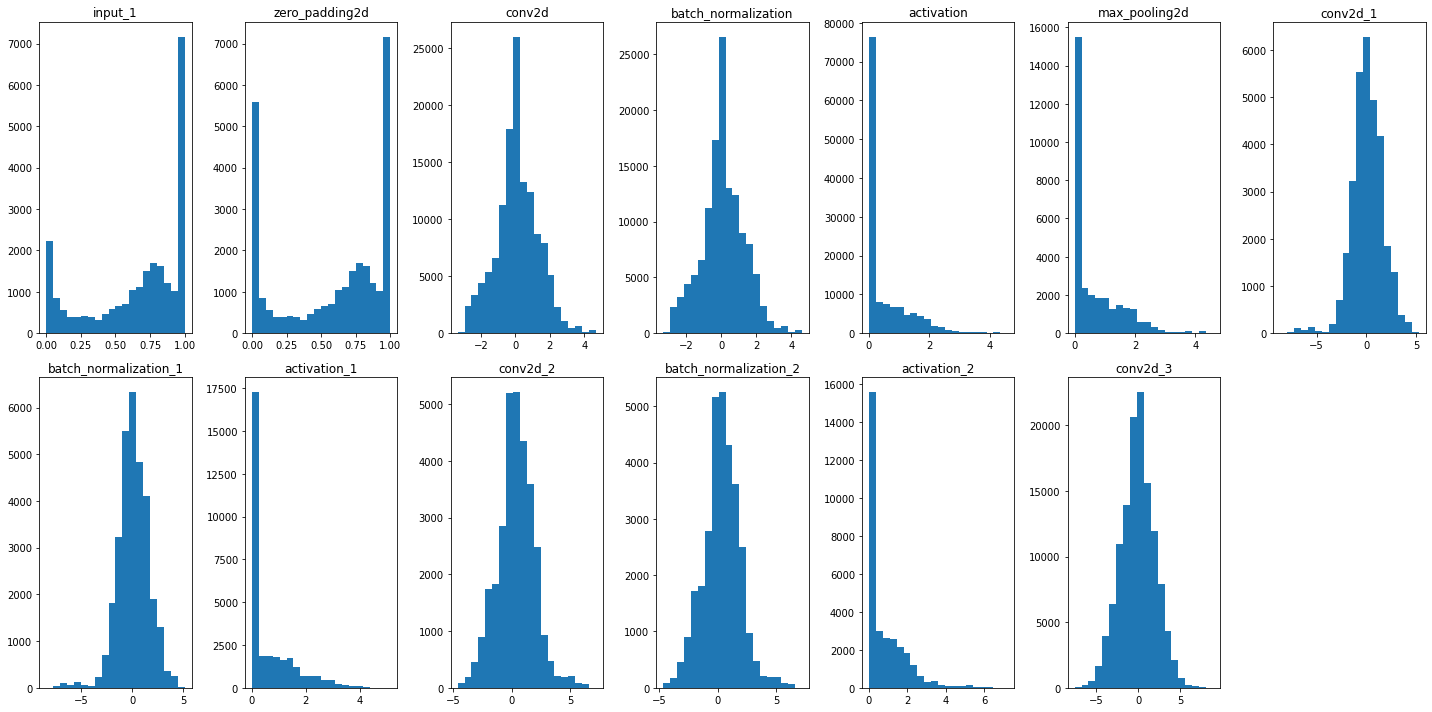

In [ ]:
def plot_activations(model, img):
    """
    Arguments:
        model
        img -- numpy array of shape (height, width, channel)
    """
    activations = [model.layers[0](np.expand_dims(img, axis=0))]      # Input layer
    for layer in model.layers[1:13]:         # 14th layer not match input shape because of shortcut
        # print("Inputing shape: {} to {} with expected input shape: {}".format(activations[-1].shape, layer.name, layer.input_shape))
        activations.append(layer(activations[-1], training=False))

    # plot activation distribution
    plt.figure(figsize=(20, 10))
    for i in range(len(activations)):
        plt.subplot(2, 7, i + 1)
        plt.title(model.layers[i].name)
        plt.tight_layout()
        plt.hist(activations[i].numpy().reshape(-1,), bins=20)

plot_activations(model, images[1])

In [ ]:
resnet11_histories = {}

In [ ]:
# make sure the model can overfit on very small dataset

steps_per_epoch = 5

resnet11_histories['history_11_tiny'] = compile_and_fit(
    model,
    optimizer=Adam(learning_rate=1e-5),
    train_data=tiny_train_ds,
    validation_data=tiny_val_ds,
)

clearly that the model overfit ;)) so it works

ResNet11 work very well for tiny data set.

Let's try with a small data set.

The loss will be larger (as learning curve) if we keep configuration unchanged (eg. lr).

If we change configuration (eg lr) but cannot get a better loss, than our model might be underfit. So we'll try a bigger model for small dataset

Repeat that

now, let's try with a small data set with Adam

In [ ]:
model = ResNet11(input_shape)

steps_per_epoch = 27

resnet11_histories['history_11_small'] = compile_and_fit(
    model,
    optimizer=Adam(learning_rate=1e-5),
    train_data=small_train_ds,
    validation_data=small_val_ds
)

Note: figure plotted above

We clearly see that for a bigger dataset,
* the training loss if higher
* the val loss is smaller

=> follow learning curve principle

Let' try with medium dataset

In [ ]:
model = ResNet11(input_shape)

steps_per_epoch = 64

resnet11_histories['history_11_medium'] = compile_and_fit(
    model,
    optimizer=Adam(learning_rate=5e-6),
    train_data=medium_train_ds,
    validation_data=medium_val_ds
)

still overfit quite well, the training loss even better than for small and tiny, might be because of the smaller leanrning rate

Let' try with large dataset

In [ ]:
model = ResNet11(input_shape)

max_epochs = 20
steps_per_epoch = 100

resnet11_histories['history_11_large'] = compile_and_fit(
    model,
    optimizer=Adam(learning_rate=5e-6),
    train_data=large_train_ds,
    validation_data=large_val_ds
)

still overfit quite well

In [ ]:
model = ResNet11(input_shape)

max_epochs = 40
steps_per_epoch = 137

resnet11_histories['history_11_very_large'] = compile_and_fit(
    model,
    optimizer=Adam(learning_rate=5e-6),
    train_data=train_ds_prefetch,
    validation_data=val_ds_prefetch
)

full data set seem much worse on train set, but val loss smaller => follow the learning curve

Let's try tuning for a larger lr:

large: 5e-6: slow, 0.3...

lr2: 1e-6: slower, 0.35... vẫn đang đi xuống

lr: 5e-5: slower, 0.4... có dấu hiệu đi lên



có khi xem xét dùng peicewise

In [ ]:
model = ResNet11(input_shape)

max_epochs = 40
steps_per_epoch = 137

resnet11_histories['history_11_very_large_tune_lr2'] = compile_and_fit(
    model,
    optimizer=Adam(learning_rate=1e-6),
    train_data=train_ds_prefetch,
    validation_data=val_ds_prefetch
)

the lr = 5e-6 seems the most optimistic among 3 stratergy.

in the saddle point of training loss plot: 2 reasons:

* reason 1: learning rate is large for that saddle point: Let's try using piecewise constant decay or inverse time decay
* reason 2: saddle point in the obj function: adam, momentum...

combine with training longer

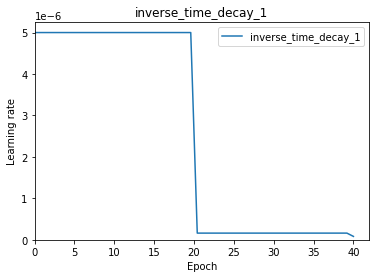

In [ ]:
inverse_time_decay_1 = InverseTimeDecay(
    initial_learning_rate=5e-6,
    decay_steps=steps_per_epoch*20,
    decay_rate=30,
    staircase=True,
    name='inverse_time_decay_1'
)

step = np.linspace(0, steps_per_epoch * max_epochs)

plot_learning_rate(step, inverse_time_decay_1)

In [ ]:
model = ResNet11(input_shape)

max_epochs = 40
steps_per_epoch = 137

resnet11_histories['inverse_time_decay_1'] = compile_and_fit(
    model,
    optimizer=Adam(inverse_time_decay_1),
    train_data=train_ds_prefetch,
    validation_data=val_ds_prefetch
)

Text(0.5, 0, 'Epochs')

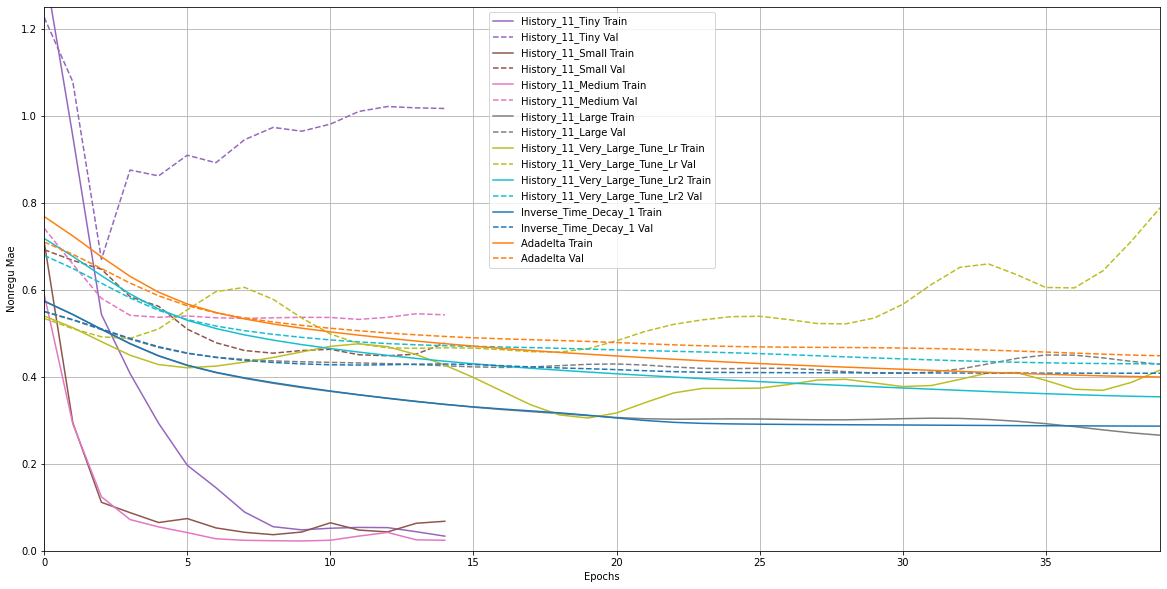

In [ ]:
plt.figure(figsize=(20, 10))
plotter.plot(resnet11_histories)
# a = plt.xscale('log')
plt.xlim([0, max(plt.xlim())])
plt.ylim([0, 1.25])
plt.xlabel('Epochs')        # <---- add [Log scale]

had already tried many cofiguration for inverse tme decay but still not work, let's try other optimization algo

In [31]:
resnet_11_adadelta_histories = {}

In [ ]:
model = ResNet11(input_shape)

max_epochs = 40
steps_per_epoch = 137

resnet_11_adadelta_histories['lr1'] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=1e-3),
    train_data=train_ds_prefetch,
    validation_data=val_ds_prefetch
)

In [ ]:
model = ResNet11(input_shape)

max_epochs = 40
steps_per_epoch = 137

resnet_11_adadelta_histories['lr2'] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=1e-1),
    train_data=train_ds_prefetch,
    validation_data=val_ds_prefetch
)

In [ ]:
model = ResNet11(input_shape)

max_epochs = 40
steps_per_epoch = 137

resnet_11_adadelta_histories['lr3'] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=1e-2),
    train_data=train_ds_prefetch,
    validation_data=val_ds_prefetch
)

In [ ]:
# this one work best
model = ResNet11(input_shape)

max_epochs = 200
steps_per_epoch = 137

resnet_11_adadelta_histories['lr4'] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=5e-2),
    train_data=train_ds_prefetch,
    validation_data=val_ds_prefetch
)

In [ ]:
# lr5: continue lr4, but with smaller lr = 5e-3
# model = ResNet11(input_shape)

max_epochs = 100
steps_per_epoch = 137

resnet_11_adadelta_histories['lr5'] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=5e-3),
    train_data=train_ds_prefetch,
    validation_data=val_ds_prefetch
)

ohhh, so after 200 epochs of Adadelta with lr = 5e-2, we train on another 100 epochs with lr = 5e-3 show a very optimistic future :))

Text(0.5, 0, 'Epochs')

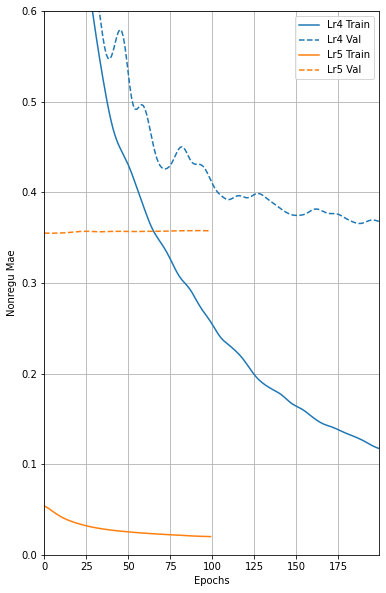

In [34]:
plt.figure(figsize=(6, 10))
plotter.plot(resnet_11_adadelta_histories)
# a = plt.xscale('log')
# plt.xlim([0, max(plt.xlim())])
plt.ylim([0, 0.6])
plt.xlabel('Epochs')        # <---- add [Log scale]

Now we're confident that the model can overfit the dataset, if I keep training, the loss might be smaller (I GUESS SO :>)

Let's use regularization!!!

#### build regu architecture

In [80]:
l = L2(0.001)

In [81]:
def identity_block_regu(X, f, filters, training=True, dropout_rate=0):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # retrieve filters
    F1, F2, F3 = filters

    # save the input value
    X_shortcut = X

    # first component of main path
    X = Conv2D(filters=F1, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # second component of main path
    X = Conv2D(filters=F2, kernel_size=f, strides=1, padding='same', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # third component of main path
    X = Conv2D(filters=F3, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)

    # add shortcut value to main path and pass it through a RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

    

In [82]:
def convolutional_block_regu(X, f, filters, s=2, training=True, dropout_rate=0):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # retrieve filters
    F1, F2, F3 = filters

    # save the input value
    X_shortcut = X

    # first component of main path
    X = Conv2D(F1, kernel_size=1, strides=s, padding='valid', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # second component of main path
    X = Conv2D(F2, kernel_size=f, strides=1, padding='same', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # third component of main path
    X = Conv2D(F3, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)

    # shortcut path
    X_shortcut = Conv2D(F3, kernel_size=1, strides=s, padding='valid', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X_shortcut)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)

    # add shortcut to main path, and pass it through a RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [84]:
def ResNet11_regu(input_shape=(64, 64, 3), dropout_rate=0):

    X_input = Input(input_shape)

    X = ZeroPadding2D(padding=3)(X_input)

    # define the input as a tensor
    X_input= Input(input_shape)

    # zero-padding
    X = ZeroPadding2D(padding=3)(X_input)

    # stage 1
    X = Conv2D(filters=64, kernel_size=7, strides=2, kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=3, strides=2)(X)

    # stage 2
    X = convolutional_block_regu(X, f=3, filters=[64, 64, 256], s=1, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[64, 64, 256], dropout_rate=dropout_rate)

    # average pooling layer
    X = AveragePooling2D(pool_size=2, strides=1, name="avg_pool")(X)
    X = Flatten()(X)
    X = Dense(4, activation='relu', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = Dense(1, kernel_regularizer=l2, kernel_initializer=he_normal(seed=seed))(X)

    # create model
    model = Model(inputs=X_input, outputs=X)

    return model


#### testing

In [41]:
resnet_11_regu_histories = {}

resnet_11_regu_histories['nonregu_300_epochs'] = resnet_11_adadelta_histories['lr5']

In [86]:
# Testing learning rate
l = L2(0.001)

# model without dropout
model = ResNet11_regu(input_shape)

optimizer = Adadelta(learning_rate=1e-2)


loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

2.3670883
1.2978876
0.73460203


In [88]:
# Testing learning rate
l = L1(0.001)

# model without dropout
model = ResNet11_regu(input_shape)

optimizer = Adadelta(learning_rate=1e-2)


loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

2.3670883
1.2978877
0.7346019


In [ ]:
# check if the regu term is present

model.layers[2].get_config()

first, we check with tiny dataset

In [ ]:
l2 = L2(0.001)

max_epochs = 100
steps_per_epoch = 5

model = ResNet11_regu(input_shape)

resnet_11_regu_histories['regu_0.001_tiny'] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=1e-4),
    train_data=tiny_train_ds,
    validation_data=tiny_val_ds
)

In [ ]:
l2 = L2(0.001)

max_epochs = 30
steps_per_epoch = 137

model = ResNet11_regu(input_shape)

resnet_11_regu_histories['regu_0.001'] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=1e-4),
)

lr = 1e-4 seems optimistics

In [ ]:
# already continue trained 15 epochs
# continue train another 30 epochs

# l2 = L2(0.001)

max_epochs = 30
steps_per_epoch = 137

# model = ResNet11_regu(input_shape)

resnet_11_regu_histories['regu_0.001_lr_1e-4_cont_2'] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=1e-4),
)

besides, let's try L1 to see if it progess better, because the edges of image is not important, so we might want sparse 

In [ ]:
l = L1(0.0001)

max_epochs = 20
steps_per_epoch = 137

model = ResNet11_regu(input_shape)

resnet_11_regu_histories['l1_0.0001_lr_5e-5'] = compile_and_fit(
    model,
    optimizer=Adam(learning_rate=5e-5),
)

vấn đề:

hội tụ rất chậm:

* do lr quá lớn? không tin lắm vì thực tế là loss vẫn đang đi xuống, chỉ là khá chậm
* do lambda lớn quá làm mô hình bị underfit?
* do đang nằm ở 1 điểm saddle? -> thử optimizer khác 

=> thử cái thứ 3 trước

In [ ]:
optimizers = []

Text(0.5, 0, 'Epochs')

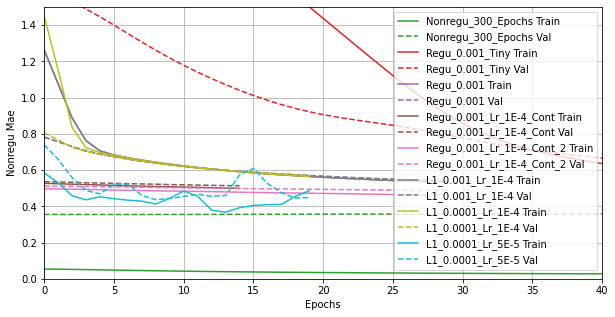

In [100]:
plt.figure(figsize=(10, 5))
plotter.plot(resnet_11_regu_histories)
# a = plt.xscale('log')
plt.xlim([0, 40])
plt.ylim([0, 1.5])
plt.xlabel('Epochs')        # <---- add [Log scale]

### Learning rate decay

CÂU HỎI: nên tối ưu cái nào trước? xác định learning rate trước hay regu trước?

Nếu thêm regu thì hàm mục tiêu thay đổi nên có thể lr không chính xác nữa

In [ ]:
from tensorflow.keras.optimizers.schedules import CosineDecay, CosineDecayRestarts, InverseTimeDecay, PiecewiseConstantDecay

In [ ]:
patience = 7    # 20
max_epochs = 15 # 90
steps_per_epoch = 27

#### true applying lr

In [ ]:
max_epochs = 15

In [ ]:
lr_histories = {}

In [ ]:
# def get_cosine_decay(initial_lr_list, decay_steps_list, alpha_list):
#     return [
#             CosineDecay(
#                 initial_learning_rate=initial_lr_list[i],
#                 decay_steps=decay_steps_list[i],
#                 alpha=alpha_list[i],
#                 name='cosine_decay_' + str(i + 1)
#                 )
#             for i in range(len(initial_lr_list))
#     ]

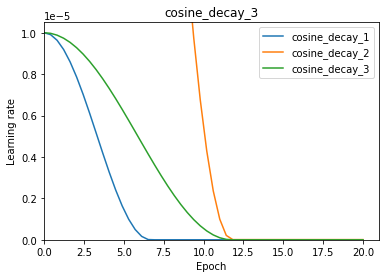

In [ ]:
# step = np.linspace(0, steps_per_epoch * 20) # max_epochs

# schedulers = get_cosine_decay(
#     initial_lr_list=[1e-5, 1e-4, 1e-5],
#     decay_steps_list=[steps_per_epoch * 20/3, steps_per_epoch * 20/1.7, steps_per_epoch * 20/1.7],
#     alpha_list=[1e-4, 1e-4, 1e-6]
# )


# for scheduler in schedulers:
#     plot_learning_rate(step, scheduler)

In [ ]:
def try_learning_rates(schedulers):

    for scheduler in schedulers:
        model = ResNet11(input_shape)

        shutil.rmtree(logdir/('lr/' + scheduler.name), ignore_errors=True)

        np.random.seed(seed)

        lr_histories[scheduler.name] = compile_and_fit(
            model,
            callbacks=get_callback('lr/' + scheduler.name),
            optimizer=Adam(scheduler)
        )

try_learning_rates(schedulers)

In [ ]:
model = ResNet11(input_shape)

optimizer = Adam(learning_rate=1e-5)

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

2.3670883
1.5734271


In [ ]:
# model = ResNet11(input_shape)

# shutil.rmtree(logdir/'lr/cosine_decay_restarts', ignore_errors=True)

# np.random.seed(seed)

# lr_histories['cosine_decay_restarts'] = compile_and_fit(
#     model,
#     callbacks=get_callback('lr/cosine_decay_restarts'),
#     optimizer=Adam(cosine_decay_restarts)
# )

In [ ]:
# model = ResNet11(input_shape)

# shutil.rmtree(logdir/'lr/inverse_time_decay', ignore_errors=True)

# np.random.seed(seed)

# lr_histories['inverse_time_decay'] = compile_and_fit(
#     model,
#     callbacks=get_callback('lr/inverse_time_decay'),
#     optimizer=Adam(inverse_time_decay)
# )

### Regularizations

In [ ]:
regularization_histories = {}

In [ ]:
model_regu_dropout = ResNet50(input_shape=input_shape, kernel_regularizer='l2', dropout=True)

shutil.rmtree(logdir/'regularizations/regu_dropout', ignore_errors=True)

np.random.seed(seed)

regularization_histories['regu_dropout'] = compile_and_fit(
    model_regu_dropout,
    name=get_callback('regularizations/regu_dropout'),
    optimizer=Adam(cosine_decay),
)

In [ ]:
model_raw = ResNet50(input_shape=input_shape)

shutil.rmtree(logdir/'regularizations/raw', ignore_errors=True)

np.random.seed(seed)

regularization_histories['raw'] = compile_and_fit(
    model_raw,
    name=get_callback('regularizations/raw'),
    optimizer=Adam(cosine_decay),
)

In [ ]:
model_regu = ResNet50(input_shape=input_shape, kernel_regularizer='l2')

shutil.rmtree(logdir/'regularizations/regu', ignore_errors=True)

np.random.seed(seed)

regularization_histories['regu'] = compile_and_fit(
    model_regu,
    name=get_callback('regularizations/regu'),
    optimizer=Adam(cosine_decay),
)

In [ ]:
model_dropout = ResNet50(input_shape=input_shape, dropout=True)

shutil.rmtree(logdir/'regularizations/dropout', ignore_errors=True)

np.random.seed(seed)

regularization_histories['dropout'] = compile_and_fit(
    model_dropout,
    name=get_callback('regularizations/dropout'),
    optimizer=Adam(cosine_decay),
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'Epochs')

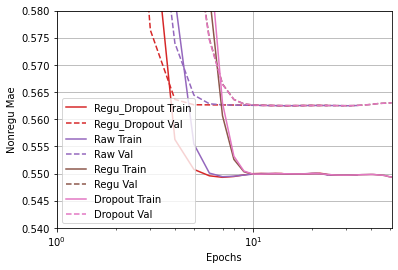

In [ ]:
plotter.plot(regularization_histories)
a = plt.xscale('log')
plt.xlim([0, max(plt.xlim())])
plt.ylim([0.54, 0.58])
plt.xlabel('Epochs')        # <---- add [Log scale]

### Optimizers

In [ ]:
optimizer_histories = {}

In [ ]:
shutil.rmtree(logdir/"optimizers/adam", ignore_errors=True)
shutil.copytree(logdir/"regularizations/raw", logdir/"optimizers/adam")

PosixPath('/tmp/tmprx6rvzt2/tensorboard_logs/optimizers/adam')

In [ ]:
# # ĐỢI TAB REGU CHẠY XONG RỒI MANG NHÁNH LOGDIR CỦA NÓ SANG ĐÂY ĐỠ TỐN CÔNG
# # NHỚ CHỈNH LẠI TÊN CÁC THỨ

# shutil.rmtree(logdir/"optimizers/adam", ignore_errors=True)

# model = ResNet50(input_shape=input_shape)

np.random.seed(seed)

# optimizer_histories['adam'] = compile_and_fit(
#     model,
#     name=get_callback('optimizers/adam'),
#     optimizer='adam'
# )

In [ ]:
# ĐỢI TAB REGU CHẠY XONG RỒI MANG NHÁNH LOGDIR CỦA NÓ SANG ĐÂY ĐỠ TỐN CÔNG
# NHỚ CHỈNH LẠI TÊN CÁC THỨ
model = ResNet50(input_shape=input_shape)

shutil.rmtree(logdir/"optimizers/sgd_momentum", ignore_errors=True)

np.random.seed(seed)

optimizer_histories['sgd_momentum'] = compile_and_fit(
    model,
    name=get_callback('optimizers/sgd_momentum'),
    optimizer=SGD(momentum=0.9)
)

In [ ]:
# ĐỢI TAB REGU CHẠY XONG RỒI MANG NHÁNH LOGDIR CỦA NÓ SANG ĐÂY ĐỠ TỐN CÔNG
# NHỚ CHỈNH LẠI TÊN CÁC THỨ
model = ResNet50(input_shape=input_shape)

shutil.rmtree(logdir/"optimizers/sgd_nesterov", ignore_errors=True)

np.random.seed(seed)

optimizer_histories['sgd_nesterov'] = compile_and_fit(
    model,
    name=get_callback('optimizers/sgd_nesterov'),
    optimizer=SGD(momentum=0.9, nesterov=True)
)

In [ ]:
plotter.plot(optimizer_histories)
# a = plt.xscale('log')
plt.xlim([0, max(plt.xlim())])
plt.ylim([-1, 5])
plt.xlabel('Epochs') # [Log scale]

### TensorBoard

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir {logdir}/lr

In [ ]:
predictions = tf.data.Dataset.from_tensor_slices(model.predict(val_ds_prefetch)).batch(batch_size)

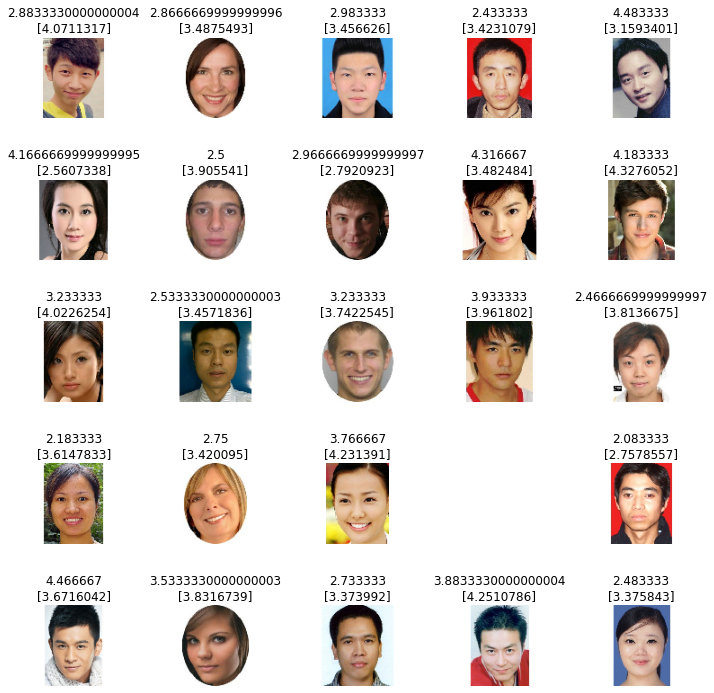

In [ ]:
plt.figure(figsize=(10, 10))
for images, true_scores in val_ds_prefetch.take(1):
    for pred_scores in predictions.take(1):
        for i in range(25):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i])
            plt.title('{}\n{}'.format(true_scores[i], pred_scores[i]))
            plt.tight_layout()
            plt.axis("off")